In [1]:
from IPython.display import Image
import numpy as np
import pandas as pd
import scipy as sp
import pymc3 as pm
import seaborn as sns
import theano as th
import theano.tensor as tt

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import EllipseCollection
import matplotlib.collections as clt
from functools import reduce

from plotutils import addtxt
mpl.style.use(['./scripts/theme_bw.mplstyle', './scripts/presentation.mplstyle'])

In [33]:
def K_Linear(x1,x2):
    return np.multiply.outer(x1,x2)
def K_SquareExp(x1,x2,l=1.0):
    return np.exp(-0.5*np.subtract.outer(x1,x2)**2/l**2)
def K_WhiteNoise(x1,x2,σ=1.0):
    r = np.abs(np.subtract.outer(x1,x2))
    return np.where(r == 0, 1.0, 0.0)
def K_OrnsteinUhlenbeck(x1,x2,l=1.0):
    return np.exp(-0.5*np.abs(np.subtract.outer(x1,x2))/l)
def K_Matern32(x1,x2,l=1.0):
    r = np.sqrt(3)*np.abs(np.subtract.outer(x1,x2))/l
    return (1.0 + r)*np.exp(-r)
def K_Matern52(x1,x2,l=1.0):
    r = np.sqrt(5)*np.abs(np.subtract.outer(x1,x2))/l
    return (1.0 + r + r**2/3)*np.exp(-r)

def GP(μ, K): # Rasmussen pg. 201
    L = np.linalg.cholesky(K+1e-6*np.eye(len(μ)))
    u = np.random.randn(len(μ))
    return μ + np.dot(L, u)
def GPpost(xs, xt, yt, μ, K): # Rasmussen pg. 16
    Ktt = K(xt, xt) # K
    Kss = K(xs, xs) # K**
    Kts = K(xt, xs) # K*
    Kttinv = np.linalg.inv(Ktt)

    μpost = μ + np.linalg.multi_dot([np.transpose(Kts), Kttinv, yt-μ])  # posterior avg
    Kpost = Kss - np.linalg.multi_dot([np.transpose(Kts), Kttinv, Kts]) # posterior cov
    return μpost, Kpost

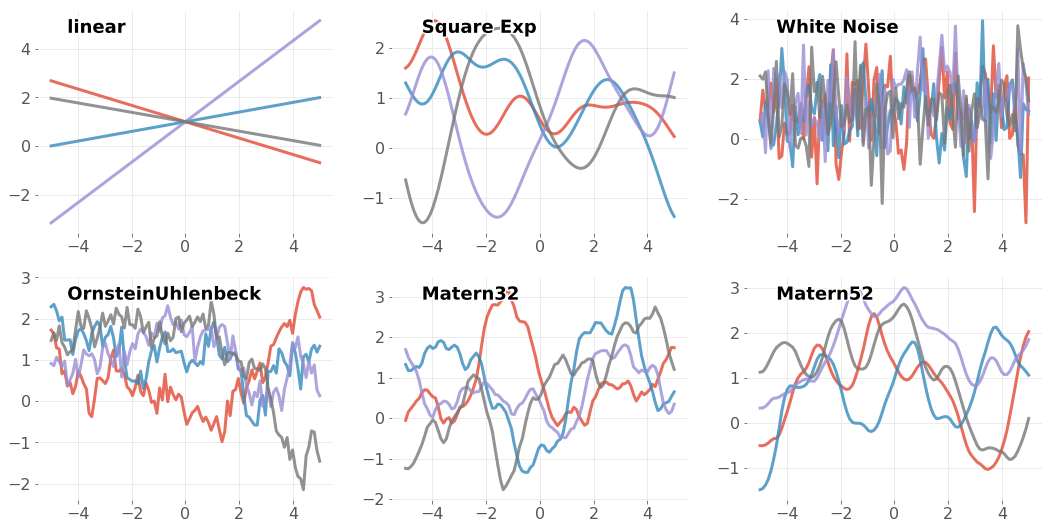

In [27]:
fig, axes = plt.subplots(figsize=(18,9), ncols=3, nrows=2)

Ks = [K_Linear, K_SquareExp, K_WhiteNoise, K_OrnsteinUhlenbeck, K_Matern32, K_Matern52]
Kl = ['linear', 'Square Exp', 'White Noise', 'OrnsteinUhlenbeck', 'Matern32', 'Matern52']

x  = np.linspace(-5,5, num=100) # grid
μ  = np.ones_like(x)
for ax,K,l in zip(axes.flatten(), Ks, Kl):
    addtxt(ax,0.1,0.9,l,fs=18)
    for i in range(4):
        ax.plot(x, GP(μ, K(x,x)), alpha=0.8)

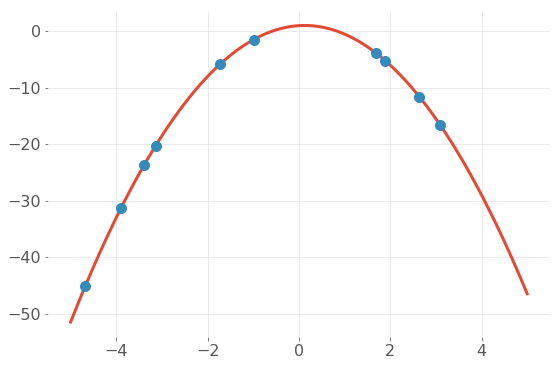

In [37]:
fig, ax = plt.subplots(figsize=(9,6))
x = np.linspace(-5,5,num=500)
y = (1 + 0.5*x - 2*x**2)
#y = np.sin(x)
i = np.random.choice(len(x),size=10, replace=False)
xt= x[i]
yt= y[i]
ax.plot(x, y)
ax.plot(xt, yt, marker='o', ls='none')

In [51]:
xs    = x
μpost,Kpost = GPpost(xs, xt, yt, 0.0, K_Matern52)
ys    = np.array([GP(μpost, Kpost) for i in range(1000)]) # draw 1000 random functions from posterior
yavg  = np.average(ys, axis=0) # average estimate
ysig  = np.std(ys, axis=0)     # error estimate

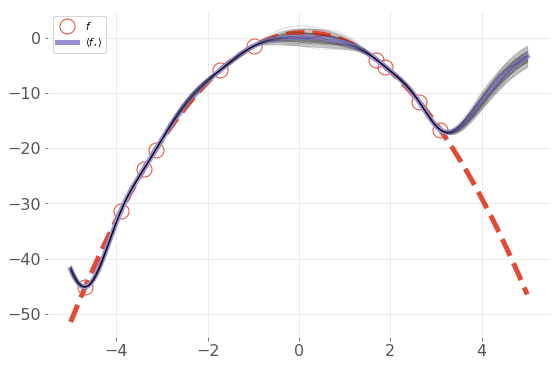

In [54]:
fig, ax = plt.subplots(figsize=(9,6))
l, = ax.plot(x, y, ls='--', lw=5)  # original function
ax.plot(xt, yt, ls='None', marker='o', ms=15, mec=l.get_color(),mfc='None', label=r'$f$') # training data
ax.plot(xs, μpost, lw=5, label=r'$\langle f_{\star}\rangle$') # avg posterior
ax.fill_between(xs, yavg - ysig, yavg + ysig, color='grey', alpha=0.8) # avg+/-sigma
ax.fill_between(xs, yavg - 2*ysig, yavg + 2*ysig, color='grey', alpha=0.4) # avg+/-2sigma
for i in range(30):
    ax.plot(xs, ys[i], color='k', alpha=0.1, lw=0.8)
ax.legend()